We will be predicting the Fire Weather Index (FWI), a numerical rating representing potential wildfire intensity, based on weather conditions like temperature, wind speed, relative humidity, and precipitation. A higher FWI indicate greater fire danger, increased spread rates, and harder suppression.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


Use header=1 to not consider the first row.

In [35]:
dataset = pd.read_csv('datasets/Algerian_Forest_Fire.csv', header = 1)
dataset.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


In [37]:
dataset.shape

(246, 14)

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          246 non-null    object
 1   month        245 non-null    object
 2   year         245 non-null    object
 3   Temperature  245 non-null    object
 4    RH          245 non-null    object
 5    Ws          245 non-null    object
 6   Rain         245 non-null    object
 7   FFMC         245 non-null    object
 8   DMC          245 non-null    object
 9   DC           245 non-null    object
 10  ISI          245 non-null    object
 11  BUI          245 non-null    object
 12  FWI          245 non-null    object
 13  Classes      244 non-null    object
dtypes: object(14)
memory usage: 27.0+ KB


## Data Cleaning

In [39]:
dataset.isnull().sum()

day            0
month          1
year           1
Temperature    1
 RH            1
 Ws            1
Rain           1
FFMC           1
DMC            1
DC             1
ISI            1
BUI            1
FWI            1
Classes        2
dtype: int64

In [40]:
# To retrive only the rows have any null value
dataset[dataset.isnull().any(axis=1)]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
122,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,14,07,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NaN


The dataset contains data from two regions and is split from the 122nd row as we can see above. To make it easier to train the model we will create a new feature called "region" which will indicate which region the data belongs from - Bejaija Region(0) or Sidi-Bel Abbes Region(1)

In [41]:
dataset.loc[:122, 'Region'] = 0
dataset.loc[122:, 'Region'] = 1
df = dataset

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          246 non-null    object 
 1   month        245 non-null    object 
 2   year         245 non-null    object 
 3   Temperature  245 non-null    object 
 4    RH          245 non-null    object 
 5    Ws          245 non-null    object 
 6   Rain         245 non-null    object 
 7   FFMC         245 non-null    object 
 8   DMC          245 non-null    object 
 9   DC           245 non-null    object 
 10  ISI          245 non-null    object 
 11  BUI          245 non-null    object 
 12  FWI          245 non-null    object 
 13  Classes      244 non-null    object 
 14  Region       246 non-null    float64
dtypes: float64(1), object(14)
memory usage: 29.0+ KB


In [43]:
df[['Region']] = df[['Region']].astype('int')
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,0
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire,0
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire,0


Removing all null values

In [44]:
df = df.dropna().reset_index(drop=True)

In [45]:
df.isnull().sum()

day            0
month          0
year           0
Temperature    0
 RH            0
 Ws            0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64

In [46]:
# There is a row where the other region data starts so we need to drop that
df.iloc[122]

day                    day
month                month
year                  year
Temperature    Temperature
 RH                     RH
 Ws                     Ws
Rain                 Rain 
FFMC                  FFMC
DMC                    DMC
DC                      DC
ISI                    ISI
BUI                    BUI
FWI                    FWI
Classes          Classes  
Region                   1
Name: 122, dtype: object

In [47]:
df = df.drop(122).reset_index(drop=True)

In [48]:
df.iloc[[122]]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
122,01,06,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire,1


In [49]:
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ', 'Region'],
      dtype='object')

In [50]:
# SOme column names have extra white spaces, we will remove them
df.columns = df.columns.str.strip()

Convert object dtype to int

In [54]:
df[['day', 'month', 'year', 'Temperature', 'RH', 'Ws']]= df[['day', 'month', 'year', 'Temperature', 'RH', 'Ws']].astype(int)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          243 non-null    int64 
 1   month        243 non-null    int64 
 2   year         243 non-null    int64 
 3   Temperature  243 non-null    int64 
 4   RH           243 non-null    int64 
 5   Ws           243 non-null    int64 
 6   Rain         243 non-null    object
 7   FFMC         243 non-null    object
 8   DMC          243 non-null    object
 9   DC           243 non-null    object
 10  ISI          243 non-null    object
 11  BUI          243 non-null    object
 12  FWI          243 non-null    object
 13  Classes      243 non-null    object
 14  Region       243 non-null    int64 
dtypes: int64(7), object(8)
memory usage: 28.6+ KB


In [56]:
df.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

Finding all the columns where dtype is object and coverting them to float

In [59]:
feat = [features for features in df.columns if df[features].dtype == 'O']

In [65]:
for i in feat:
    if i != 'Classes':
        df[i] = df[i].astype(float)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  FWI          243 non-null    float64
 13  Classes      243 non-null    object 
 14  Region       243 non-null    int64  
dtypes: float64(7), int64(7), object(1)
memory usage: 28.6+ KB


## EDA

In [83]:
# We don't require the day month and year to predict the FWI currently so we drop it
df_copy = df.drop(['day', 'month', 'year'], axis=1)
df_copy.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [84]:
df_copy['Classes'].value_counts()

Classes
fire             131
not fire         101
fire               4
fire               2
not fire           2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64

There is some additional spaces available in the classes so it is leading to multiple classes

In [85]:
# Encode the class categories - fire and not fire

# This doesn't work because of the extra spaces
# df_copy['Classes'] = np.where(df_copy['Classes']=='not fire', 0, 1)

df_copy['Classes'] = np.where(df_copy['Classes'].str.contains('not fire'), 0, 1)

In [86]:
df_copy.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0


In [87]:
df_copy['Classes'].value_counts()

Classes
1    137
0    106
Name: count, dtype: int64

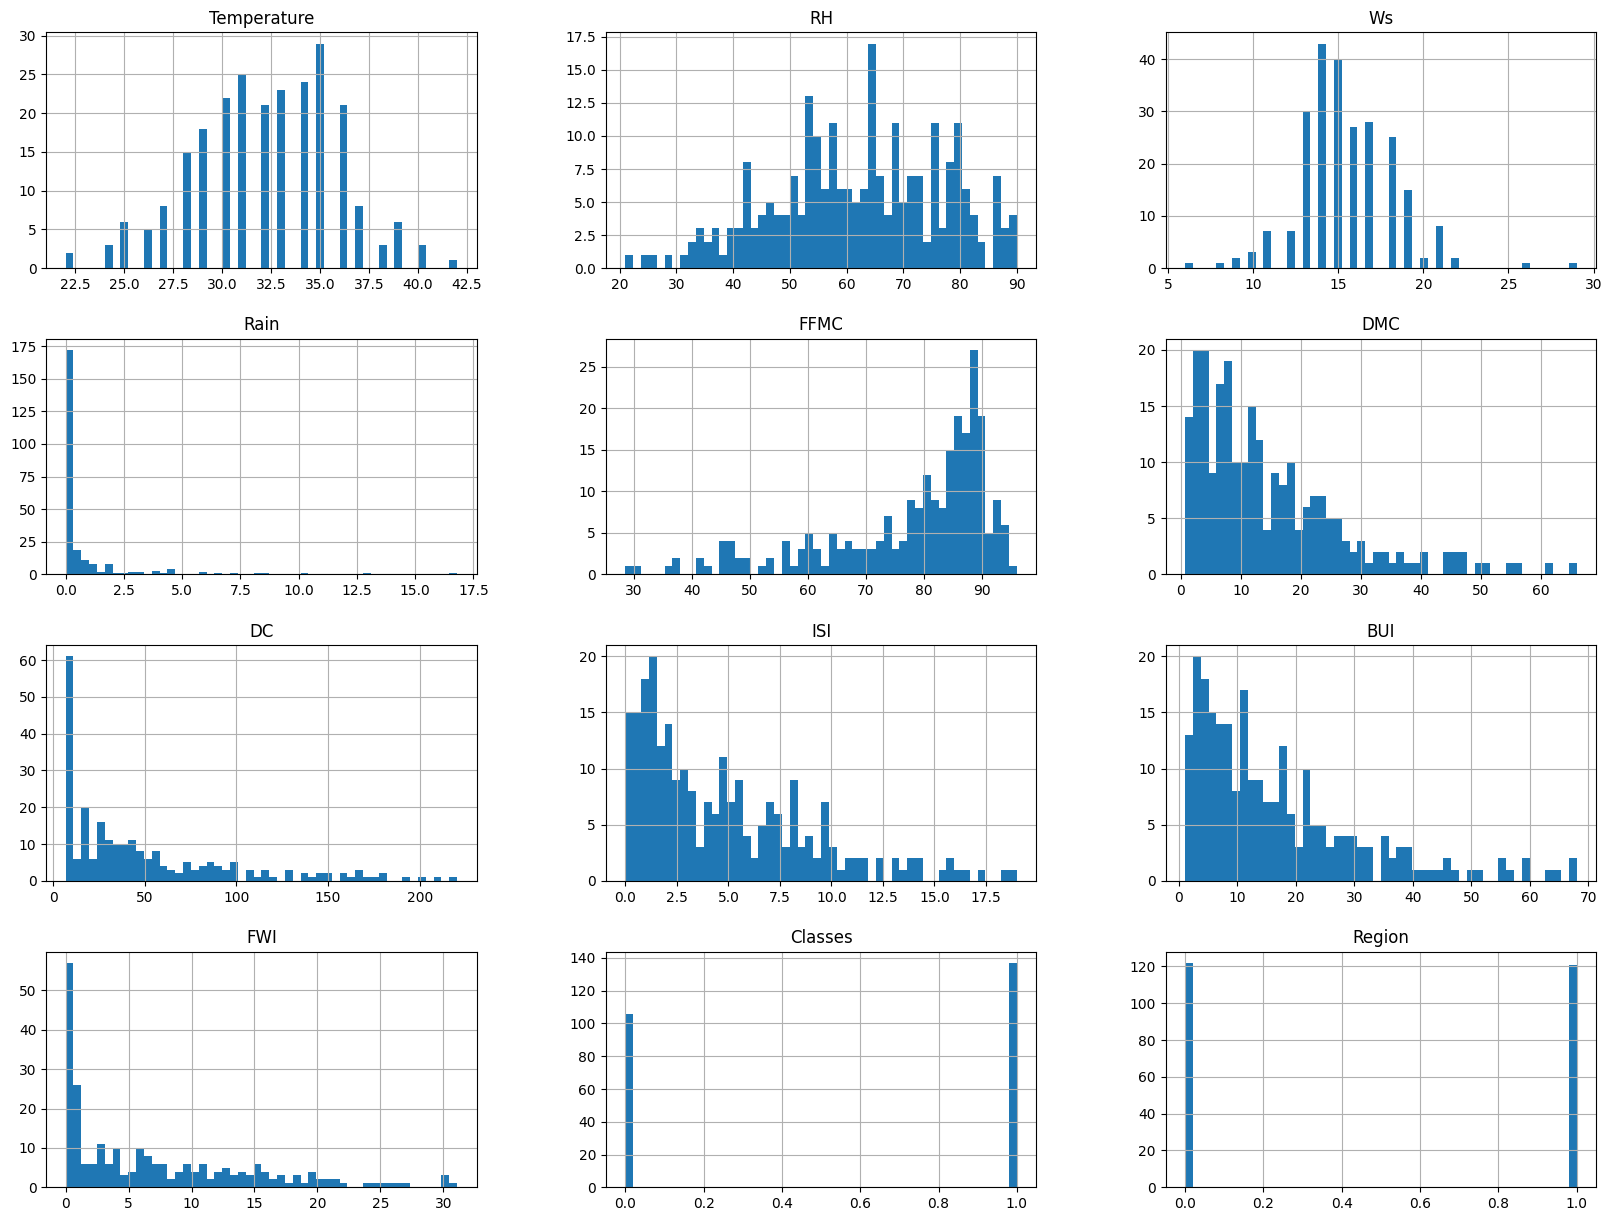

In [92]:
import seaborn as sns
df_copy.hist(bins=50, figsize=(20, 15))
plt.show()

In [95]:
# Extracting the fire and not fire percentage 
percent = df_copy['Classes'].value_counts(normalize=True)*100

Text(0.5, 1.0, 'Pie CHart of CLasses')

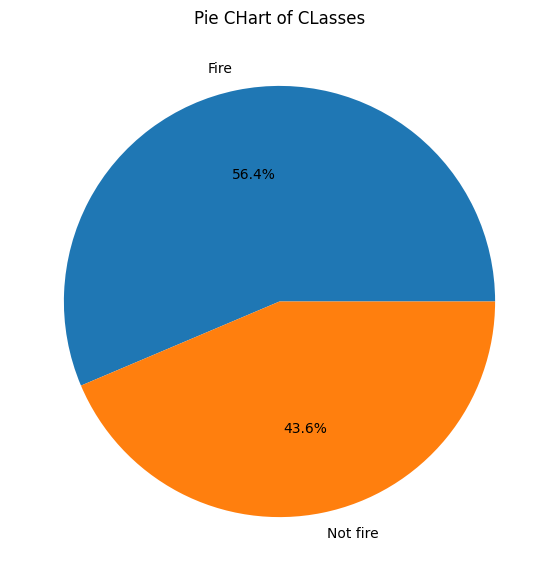

In [100]:
# Plotting a pie chart
class_labels = ['Fire', 'Not fire']
plt.figure(figsize=(12, 7))
plt.pie(percent, labels = class_labels, autopct='%1.1f%%')
plt.title("Pie CHart of CLasses")


In [101]:
# FInd correlation
df_copy.corr()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
Temperature,1.000000,-0.651400,-0.284510,-0.326492,0.676568,0.485687,0.376284,0.603871,0.459789,0.566670,0.516015,0.269555
RH,-0.651400,1.000000,0.244048,0.222356,-0.644873,-0.408519,-0.226941,-0.686667,-0.353841,-0.580957,-0.432161,-0.402682
Ws,-0.284510,0.244048,1.000000,0.171506,-0.166548,-0.000721,0.079135,0.008532,0.031438,0.032368,-0.069964,-0.181160
Rain,-0.326492,0.222356,0.171506,1.000000,-0.543906,-0.288773,-0.298023,-0.347484,-0.299852,-0.324422,-0.379097,-0.040013
FFMC,0.676568,-0.644873,-0.166548,-0.543906,1.000000,0.603608,0.507397,0.740007,0.592011,0.691132,0.769492,0.222241
DMC,0.485687,-0.408519,-0.000721,-0.288773,0.603608,1.000000,0.875925,0.680454,0.982248,0.875864,0.585658,0.192089
DC,0.376284,-0.226941,0.079135,-0.298023,0.507397,0.875925,1.000000,0.508643,0.941988,0.739521,0.511123,-0.078734
ISI,0.603871,-0.686667,0.008532,-0.347484,0.740007,0.680454,0.508643,1.000000,0.644093,0.922895,0.735197,0.263197
BUI,0.459789,-0.353841,0.031438,-0.299852,0.592011,0.982248,0.941988,0.644093,1.000000,0.857973,0.586639,0.089408
FWI,0.566670,-0.580957,0.032368,-0.324422,0.691132,0.875864,0.739521,0.922895,0.857973,1.000000,0.719216,0.197102


<Axes: >

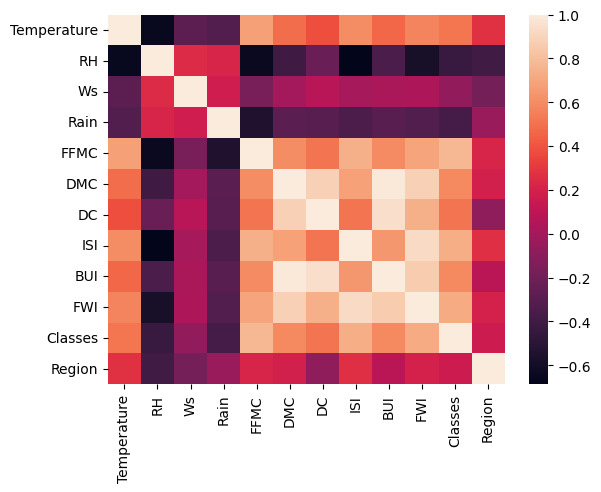

In [103]:
sns.heatmap(df_copy.corr())

<Axes: ylabel='FWI'>

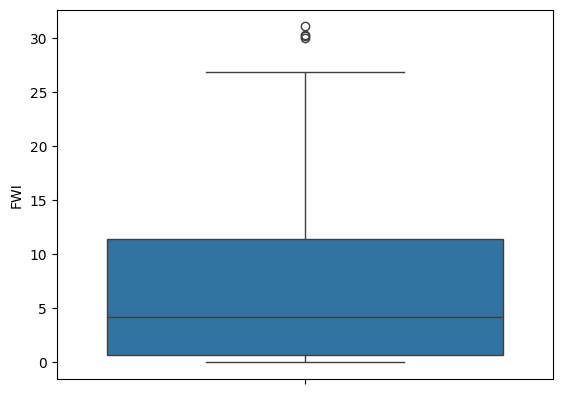

In [104]:
# To check outliers
sns.boxplot(df_copy['FWI'])

In [105]:
df_copy.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0


In [111]:
df['Classes']=np.where(df['Classes'].str.contains('not fire'),'not fire','fire')

Text(0.5, 1.0, 'Monthly Fire Analysis')

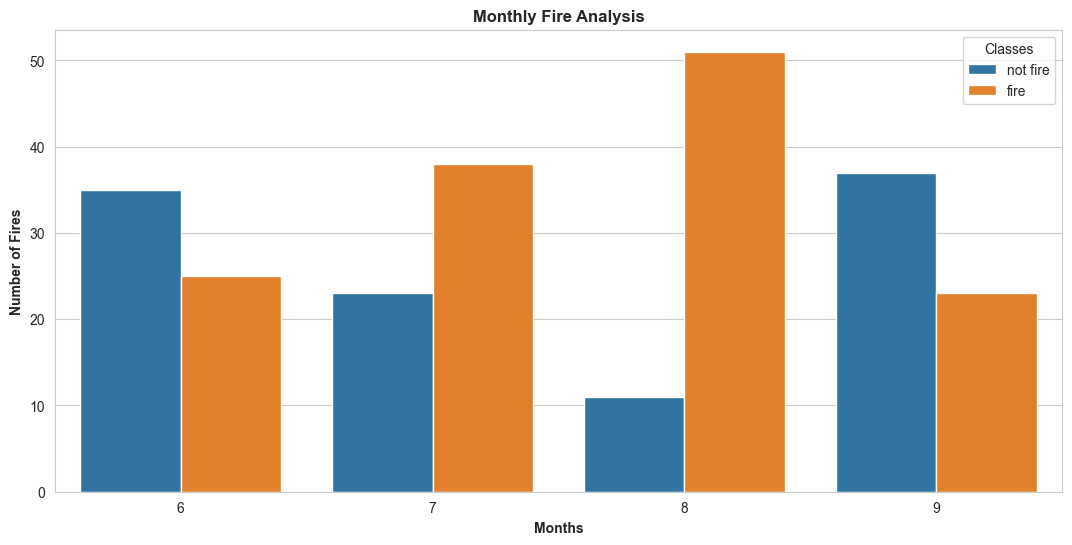

In [114]:
## Monthly Fire Analysis
plt.subplots(figsize=(13,6))
sns.set_style('whitegrid')
sns.countplot(x='month',hue='Classes',data=df)
plt.ylabel('Number of Fires',weight='bold')
plt.xlabel('Months',weight='bold')
plt.title("Monthly Fire Analysis",weight='bold')

This plot tells us that the max number of fires happen in August and the least in Septemeber. 
The number of fires increases in subsequent months from June - August.

In [115]:
df.head(10)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0
5,6,6,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire,0
6,7,6,2012,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire,0
7,8,6,2012,30,73,15,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire,0
8,9,6,2012,25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire,0
9,10,6,2012,28,79,12,0.0,73.2,9.5,46.3,1.3,12.6,0.9,not fire,0


In [118]:
df.to_csv("datasets/cleaned_Algerian_ForestFire.csv")